In [1]:
from vnstock import Quote
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
import seaborn as sns


c:\Users\HP\Desktop\Project\monte_carlo_simulation\.venv\Lib\site-packages\vnai\scope\profile.py:742: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
def get_stock_data(symbols, start_date, end_date, interval="1D"):
    """
    Fetch historical stock data for multiple symbols and save to CSV files
    
    Parameters:
    -----------
    symbols : list
        List of stock symbols 
    start_date : str
        Start date in 'YYYY-MM-DD' format
    end_date : str
        End date in 'YYYY-MM-DD' format
    interval : str, default='1D'
        Time interval for data ('1D' for daily, '1W' for weekly, etc.)
    
    Returns:
    --------
    dict
        Dictionary containing DataFrames for each symbol
    """
    data_dict = {}
    
    for symbol in symbols:
        quote = Quote(symbol=symbol, source="VCI")
        df = quote.history(start=start_date, end=end_date, interval=interval)
        data_dict[symbol] = df
       # Save to CSV with dynamic filename
        filename = f"../data/{symbol}.csv"
        df.to_csv(filename)
        print(f"Saved data for {symbol} to {filename}")
    
    return data_dict

# Example usage:
symbols = ["FPT", "VNM", "VCB", "MBB", "VCG", "NTP","HPG", "NTL","TCB", "CSV","NVL", "KDH","PDR", "TCH"]
data = get_stock_data(symbols, "2025-01-01", "2025-05-10")

Saved data for FPT to ../data/FPT.csv
Saved data for VNM to ../data/VNM.csv
Saved data for VCB to ../data/VCB.csv
Saved data for MBB to ../data/MBB.csv
Saved data for VCG to ../data/VCG.csv
Saved data for NTP to ../data/NTP.csv
Saved data for HPG to ../data/HPG.csv
Saved data for NTL to ../data/NTL.csv
Saved data for TCB to ../data/TCB.csv
Saved data for CSV to ../data/CSV.csv
Saved data for NVL to ../data/NVL.csv
Saved data for KDH to ../data/KDH.csv
Saved data for PDR to ../data/PDR.csv
Saved data for TCH to ../data/TCH.csv


In [3]:
#import data
df = pd.read_csv("../data/MBB.csv")

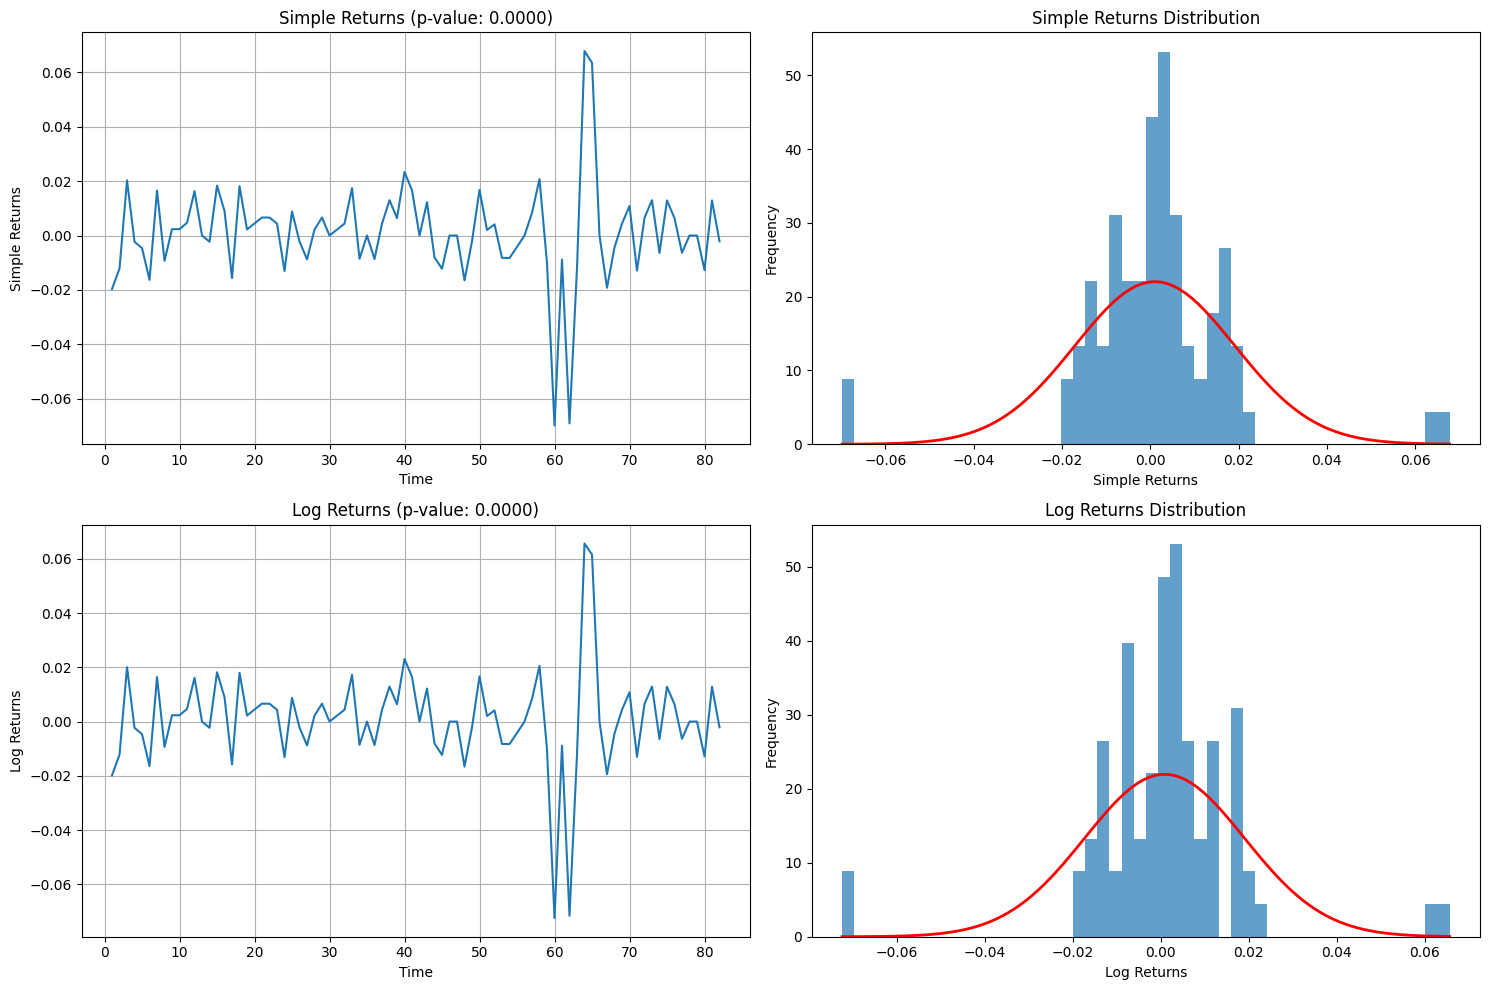

Simple returns ADF test p-value: 0.0000
Log returns ADF test p-value: 0.0000

Interpretation:
p-value < 0.05 indicates stationarity
p-value >= 0.05 indicates non-stationarity


In [4]:
def analyze_stock_returns(df):
    """
    Analyze and visualize stock returns before and after log transformation
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing stock data with 'close' column
    """
    # Sort data by time
    df = df.sort_values(by="time")
    
    # Calculate simple returns and log returns
    df['simple_return'] = df['close'].pct_change()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))
    simple_returns = df['simple_return'].dropna()
    log_returns = df['log_return'].dropna()
    
    # Perform stationarity tests
    simple_test = adfuller(simple_returns)
    simple_pvalue = simple_test[1]
    
    log_test = adfuller(log_returns)
    log_pvalue = log_test[1]
    
    # Create figure with 2x2 subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot simple returns
    ax1.plot(simple_returns)
    ax1.set_title(f'Simple Returns (p-value: {simple_pvalue:.4f})')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Simple Returns')
    ax1.grid(True)
    
    # Plot simple returns histogram with normal curve
    ax2.hist(simple_returns, bins=50, density=True, alpha=0.7)
    x = np.linspace(simple_returns.min(), simple_returns.max(), 100)
    mu = simple_returns.mean()
    sigma = simple_returns.std()
    ax2.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    ax2.set_title('Simple Returns Distribution')
    ax2.set_xlabel('Simple Returns')
    ax2.set_ylabel('Frequency')
    
    # Plot log returns
    ax3.plot(log_returns)
    ax3.set_title(f'Log Returns (p-value: {log_pvalue:.4f})')
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Log Returns')
    ax3.grid(True)
    
    # Plot log returns histogram with normal curve
    ax4.hist(log_returns, bins=50, density=True, alpha=0.7)
    x = np.linspace(log_returns.min(), log_returns.max(), 100)
    mu = log_returns.mean()
    sigma = log_returns.std()
    ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2)
    ax4.set_title('Log Returns Distribution')
    ax4.set_xlabel('Log Returns')
    ax4.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Print stationarity test results
    print(f"Simple returns ADF test p-value: {simple_pvalue:.4f}")
    print(f"Log returns ADF test p-value: {log_pvalue:.4f}")
    print("\nInterpretation:")
    print("p-value < 0.05 indicates stationarity")
    print("p-value >= 0.05 indicates non-stationarity")
    
    return log_returns

# Example usage:
returns = analyze_stock_returns(df)

In [5]:
def adf_test(series):
    """
    Perform Augmented Dickey-Fuller (ADF) test for stationarity
    
    Parameters:
    -----------
    series : pd.Series
        Time series data (log returns or simple returns)
    
    Returns:
    --------
    dict : {
        'test_statistic': float,
        'p_value': float,
        'is_stationary': bool
    }
    """
    result = adfuller(series.dropna())
    stats = {
        'test_statistic': result[0],
        'p_value': result[1],
        'is_stationary': result[1] < 0.05
    }
    
    # Print results
    print("\nAugmented Dickey-Fuller Test Results:")
    print(f"Test Statistic: {stats['test_statistic']:.4f}")
    print(f"p-value: {stats['p_value']:.4f}")
    print(f"Stationary: {'Yes' if stats['is_stationary'] else 'No'}")
    
    return stats


def describe_statistics(series):
    """
    Calculate basic statistical measures for the time series
    
    Parameters:
    -----------
    series : pd.Series
        Time series data
    
    Returns:
    --------
    dict : {
        'mean': float,
        'std': float,
        'skew': float,
        'kurtosis': float
    }
    """
    stats = {
        'mean': series.mean(),
        'std': series.std(),
        'skew': series.skew(),
        'kurtosis': series.kurtosis()
    }
    
    # Print results
    print("\nStatistical Measures:")
    print(f"Mean: {stats['mean']:.6f}")
    print(f"Standard Deviation: {stats['std']:.6f}")
    print(f"Skewness: {stats['skew']:.4f}")
    print(f"Kurtosis: {stats['kurtosis']:.4f}")
    
    return stats

# Example usage:
# Call the functions with your data
adf_results = adf_test(returns)
stats_results = describe_statistics(returns)



Augmented Dickey-Fuller Test Results:
Test Statistic: -6.0230
p-value: 0.0000
Stationary: Yes

Statistical Measures:
Mean: 0.000854
Standard Deviation: 0.018162
Skewness: -0.5611
Kurtosis: 7.8100


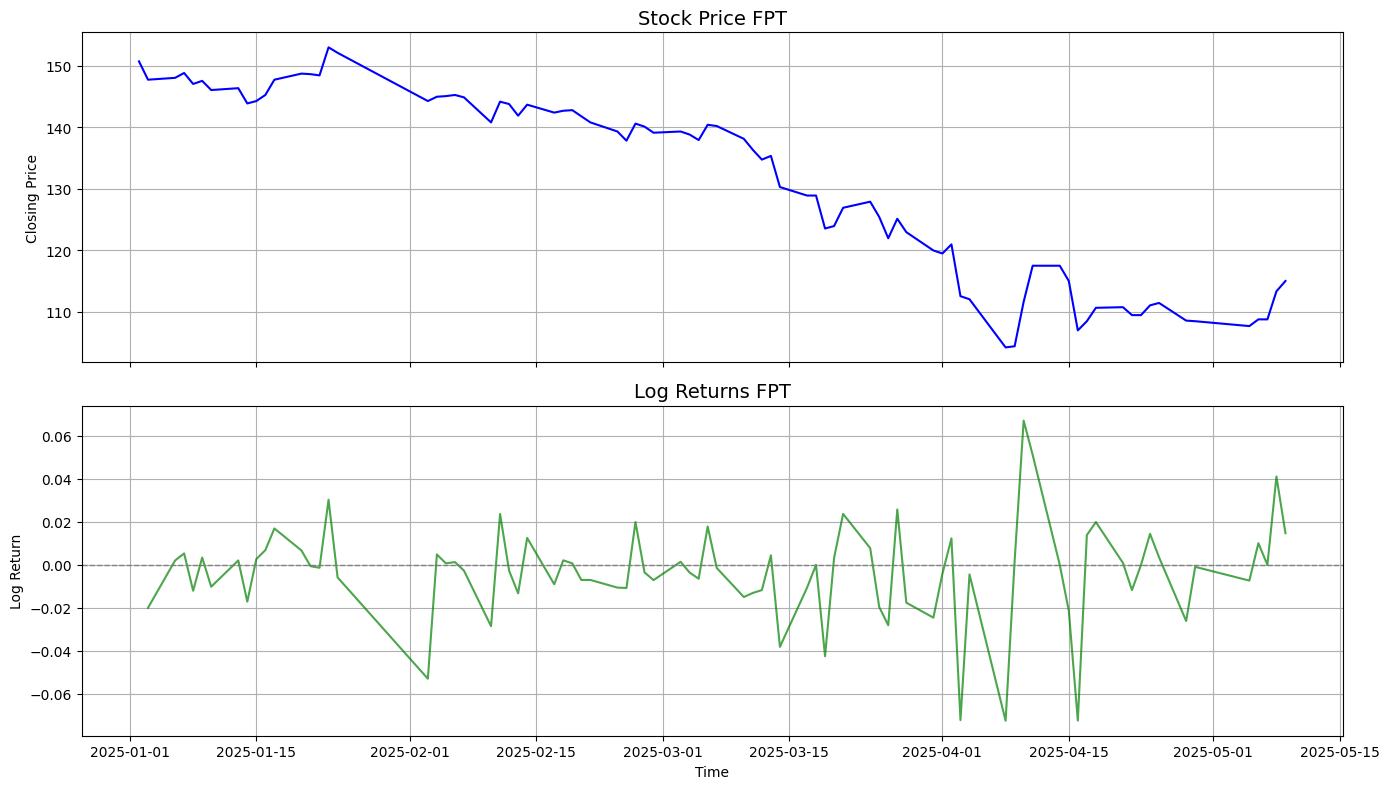

In [6]:
# Visualization and log_return

def visualize_price_and_returns(df, symbol="Stock"):
    """
    Plot price and log return charts
    """
    df = df.sort_values("time").copy()
    df['log_return'] = np.log(df['close'] / df['close'].shift(1))

    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    # Price chart
    axs[0].plot(df["time"], df["close"], color='blue')
    axs[0].set_title(f'Stock Price {symbol}', fontsize=14)
    axs[0].set_ylabel('Closing Price')
    axs[0].grid(True)

    # Log return chart
    axs[1].plot(df["time"], df["log_return"], color='green', alpha=0.7)
    axs[1].axhline(0, color='gray', lw=1, linestyle='--')
    axs[1].set_title(f'Log Returns {symbol}', fontsize=14)
    axs[1].set_ylabel('Log Return')
    axs[1].set_xlabel('Time')
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

visualize_price_and_returns(data["FPT"], symbol="FPT")

In [7]:
mu_r = returns.mean()
sigma_r = returns.std()
print(f"Profit_expected_day: {mu_r*252:.6f}")
print(f"Standard_dev_day: {sigma_r*np.sqrt(252):.6f}")


Profit_expected_day: 0.215298
Standard_dev_day: 0.288312


In [19]:
def monte_carlo_simulation(df, mu_r, sigma_r, days_list=[15, 16, 20, 180, 252], simulations=1000000):
    """
    Perform Monte Carlo simulation for multiple time horizons
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe containing price data
    mu_r : float
        Mean of log returns
    sigma_r : float
        Standard deviation of log returns
    days_list : list
        List of days to simulate
    simulations : int
        Number of simulations to run
        
    Returns:
    --------
    dict
        Dictionary containing results for each time horizon
    """
    start_price = df['close'].iloc[-1]
    results = {}
    
    for days in days_list:
        # Simulate random log returns
        simulated_returns = np.random.normal(mu_r, sigma_r, (simulations, days))
        
        # Calculate future prices from log returns
        price_paths = start_price * np.exp(np.cumsum(simulated_returns, axis=1))
        final_prices = price_paths[:, -1]
        returns = (final_prices - start_price) / start_price
        
        # Calculate statistics
        results[days] = {
            'expected_return': np.mean(returns),
            'risk': np.std(returns),
            'VaR_5': np.percentile(returns, 5),
            'price_paths': price_paths
        }
        
        # Print results
        print(f"\nResults for {days} days:")
        print(f"Expected Return: {results[days]['expected_return']:.2%}")
        print(f"Risk (Standard Deviation): {results[days]['risk']:.2%}")
        print(f"Value-at-Risk (VaR 5%): {results[days]['VaR_5']:.2%}")
    
    return results

# Example usage:
results = monte_carlo_simulation(df, mu_r, sigma_r)


Results for 15 days:
Expected Return: 1.55%
Risk (Standard Deviation): 7.14%
Value-at-Risk (VaR 5%): -9.74%

Results for 16 days:
Expected Return: 1.64%
Risk (Standard Deviation): 7.39%
Value-at-Risk (VaR 5%): -10.03%

Results for 20 days:
Expected Return: 2.05%
Risk (Standard Deviation): 8.29%
Value-at-Risk (VaR 5%): -10.98%

Results for 180 days:
Expected Return: 20.13%
Risk (Standard Deviation): 29.72%
Value-at-Risk (VaR 5%): -21.92%

Results for 252 days:
Expected Return: 29.28%
Risk (Standard Deviation): 38.12%
Value-at-Risk (VaR 5%): -22.94%


In [9]:
def monte_carlo_compare(data_dict, days=30, simulations=100000):
    """
    Run Monte Carlo simulation for multiple stock symbols and compare results

    Parameters:
    -----------
    data_dict : dict
        Dictionary containing DataFrames from get_stock_data
    days : int
        Number of days to simulate (default 252 days = 1 year)
    simulations : int
        Number of simulations per stock symbol

    Returns:
    --------
    pd.DataFrame
        Comparison results for stocks: return, risk, VaR 5%
    """
    results = []

    for symbol, df in data_dict.items():
        df = df.sort_values("time").copy()
        df['log_return'] = np.log(df['close'] / df['close'].shift(1))
        returns = df['log_return'].dropna()

        mu_r = returns.mean()
        sigma_r = returns.std()
        start_price = df['close'].iloc[-1]

        # Simulate
        simulated_returns = np.random.normal(mu_r, sigma_r, (simulations, days))
        price_paths = start_price * np.exp(np.cumsum(simulated_returns, axis=1))
        final_prices = price_paths[:, -1]
        future_returns = (final_prices - start_price) / start_price

        results.append({
            'Symbol': symbol,
            'Expected Return': np.mean(future_returns),
            'Risk (Std Dev)': np.std(future_returns),
            'VaR 5%': np.percentile(future_returns, 5),
            'Current Price': start_price
        })

    return pd.DataFrame(results).sort_values("Expected Return", ascending=False)


In [10]:
# Run Monte Carlo simulation for 30 days with 100,000 simulations per stock
compare_df = monte_carlo_compare(data_dict=data, days=30, simulations=100000)

# Display results sorted by expected return
print("\nMonte Carlo Simulation Results (30-day horizon):")
print("===============================================")
print(compare_df.to_string(index=False))



Monte Carlo Simulation Results (30-day horizon):
Symbol  Expected Return  Risk (Std Dev)    VaR 5%  Current Price
   NVL         0.077684        0.179963 -0.190099          12.30
   TCH         0.068731        0.160340 -0.172977          17.65
   VCG         0.065425        0.135131 -0.143210          19.03
   TCB         0.052206        0.112988 -0.122626          27.60
   NTP         0.051573        0.154524 -0.182381          70.44
   MBB         0.031317        0.102874 -0.128576          23.50
   HPG        -0.010912        0.119918 -0.195977          25.65
   VCB        -0.024523        0.101163 -0.181502          56.60
   VNM        -0.027308        0.096145 -0.177086          55.73
   NTL        -0.060615        0.144880 -0.278475          15.00
   PDR        -0.067174        0.134834 -0.271668          16.65
   KDH        -0.068098        0.112949 -0.241733          28.45
   FPT        -0.087244        0.113322 -0.260640         115.01
   CSV        -0.091748        0.142462 

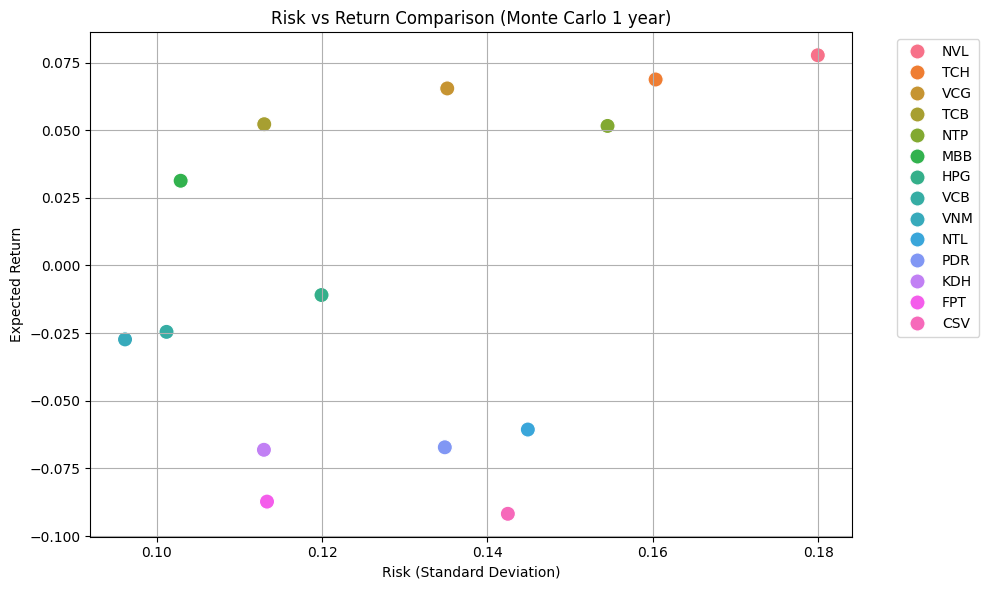

In [11]:
def plot_risk_return(df):
    """
    Plot scatter chart: Expected Return vs Risk
    """
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='Risk (Std Dev)', y='Expected Return', hue='Symbol', s=120)
    plt.title('Risk vs Return Comparison (Monte Carlo 1 year)')
    plt.xlabel('Risk (Standard Deviation)')
    plt.ylabel('Expected Return')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_risk_return(compare_df)


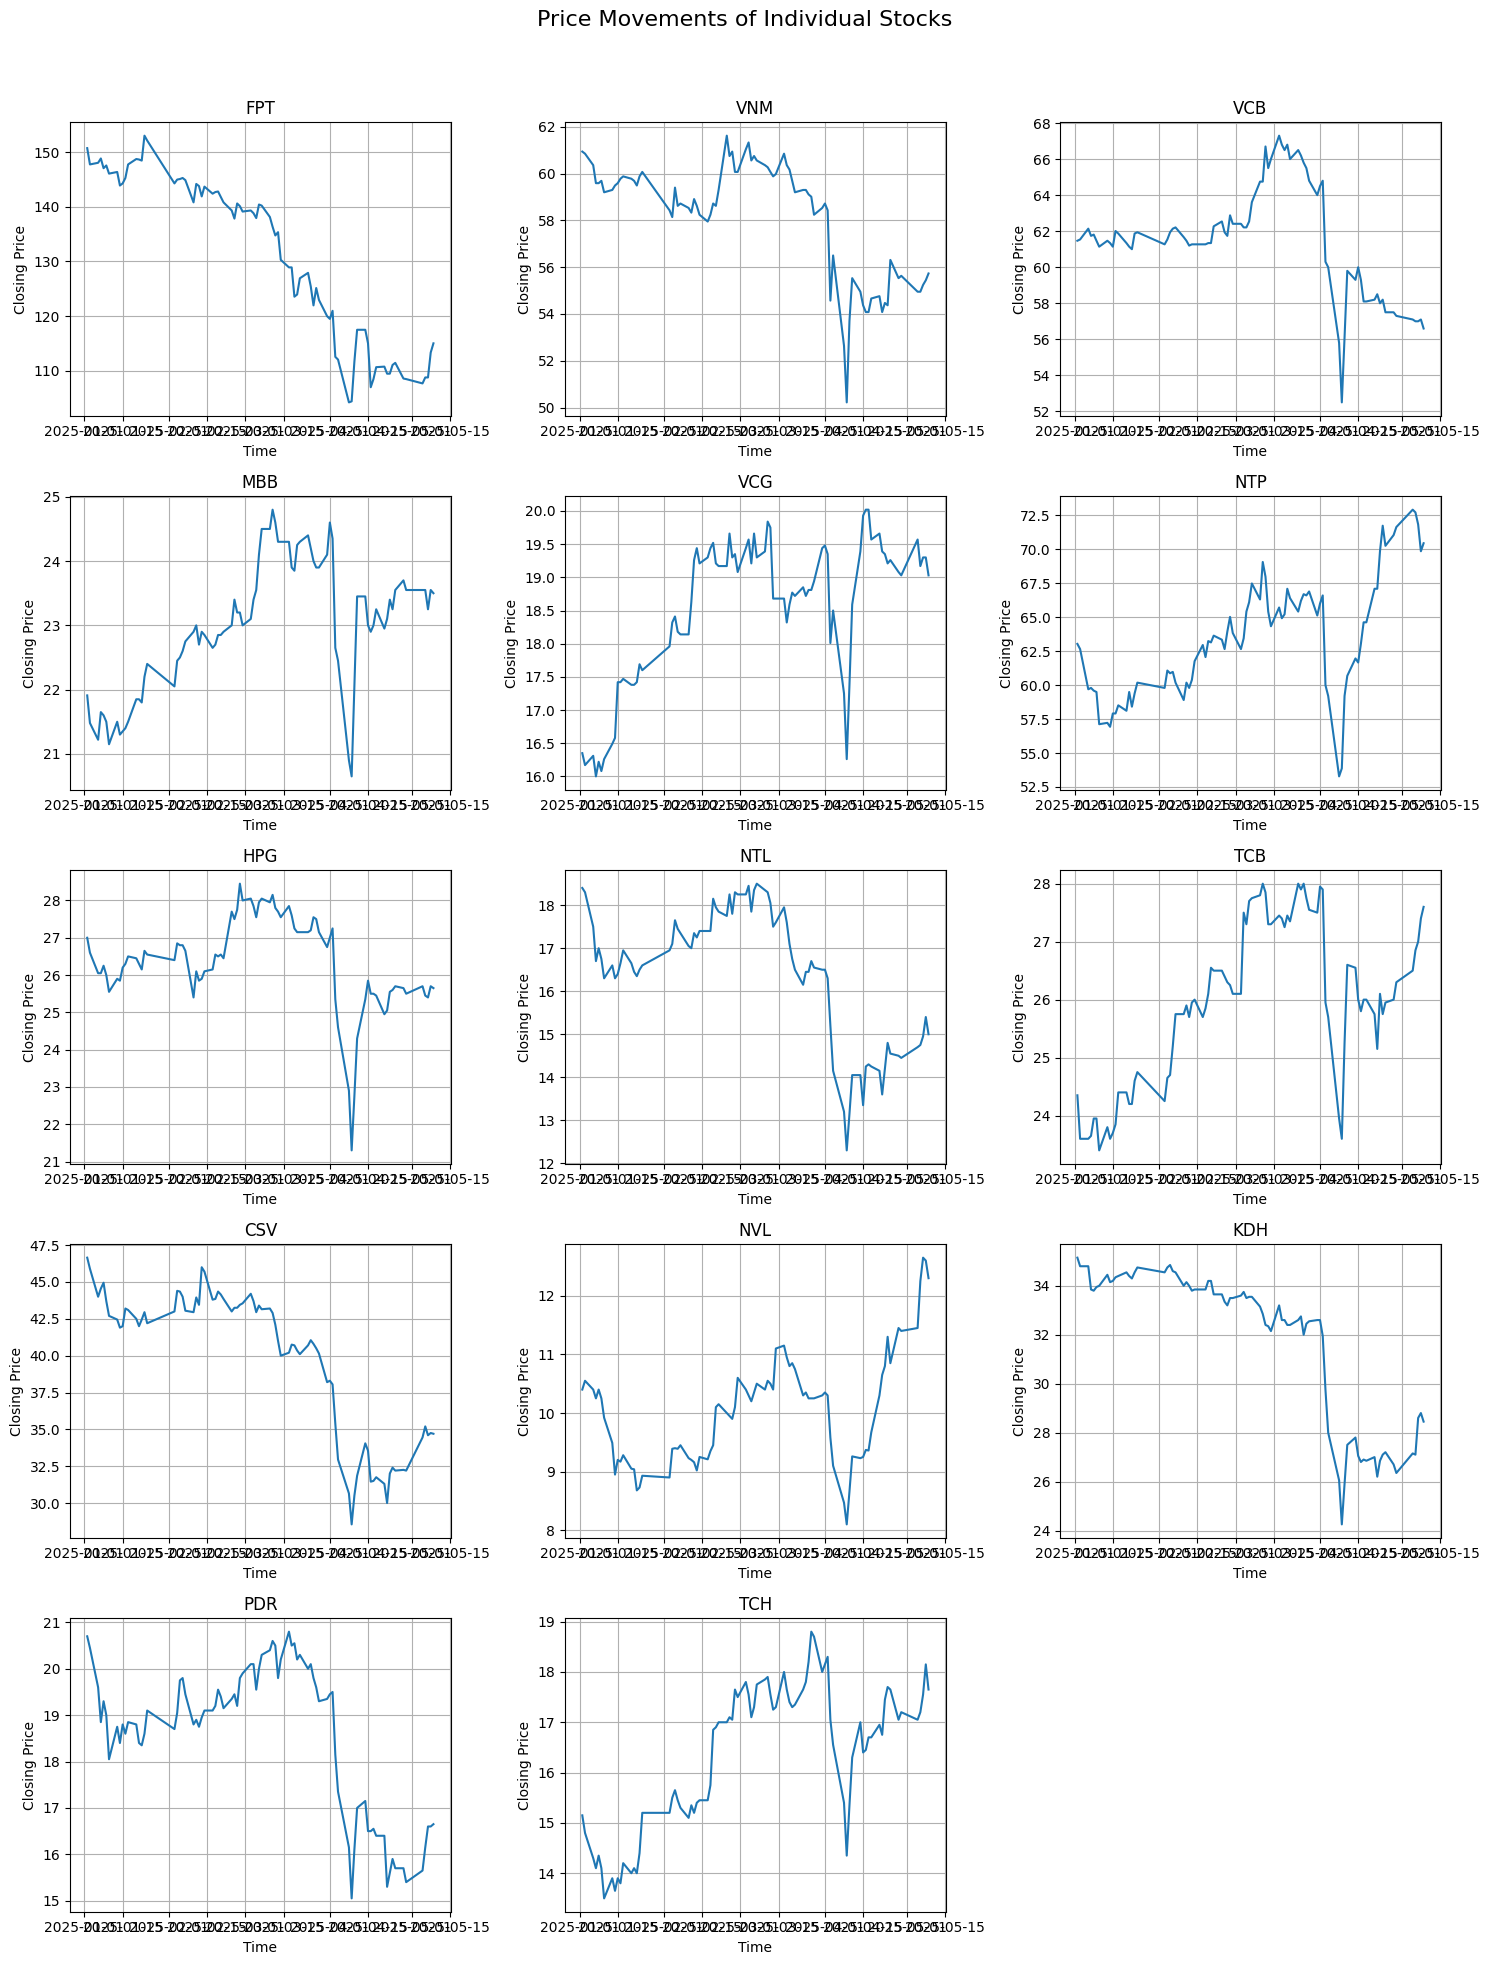

In [18]:
def plot_individual_stocks(data_dict, cols=3):
    """
    Plot price movements for each stock, one subplot per symbol

    Parameters:
    -----------
    data_dict : dict
        Dictionary containing stock DataFrames
    cols : int
        Number of columns in subplot layout
    """
    import math

    total = len(data_dict)
    rows = math.ceil(total / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows), sharex=False)
    axes = axes.flatten()  # for easier handling

    for idx, (symbol, df) in enumerate(data_dict.items()):
        ax = axes[idx]
        df_sorted = df.sort_values("time")
        ax.plot(df_sorted['time'], df_sorted['close'], label=symbol)
        ax.set_title(symbol)
        ax.set_xlabel("Time")
        ax.set_ylabel("Closing Price")
        ax.grid(True)

    # Hide empty subplots (if number of symbols is not divisible)
    for i in range(len(data_dict), len(axes)):
        fig.delaxes(axes[i])

    plt.suptitle("Price Movements of Individual Stocks", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for title
    plt.show()
plot_individual_stocks(data, cols=3)  # Or cols=3 if you want a different layout
